## Introduction

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

**How to Train [Detectron2](https://github.com/facebookresearch/detectron2) Segmentation on a Custom Dataset**

The notebook is based on official Detectron2 [colab notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) and it covers:
- Python environment setup
- Inference using pre-trained models
- Download, register and visualize COCO Format Dataset
- Configure, train and evaluate model using custom COCO Format Dataset

**Preparing a Custom Dataset**

In this tutorial, we will utilize an open source computer vision dataset from one of the 100,000+ available on [Roboflow Universe](https://universe.roboflow.com).

If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 150k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to Detectron2), training, deploying, and improving their datasets/models.

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset. Make sure to select **Instance Segmentation** Option, If you want to create your own dataset on roboflow

Useful Dataset Links

* [Helmet Instace Segmentation ](https://universe.roboflow.com/computer-vision-hx9i9/helmet_polygon_v2/dataset/4)

* [PCB Board Instance Segmentation](https://universe.roboflow.com/chip/pcb_segmentation_yolov7/dataset/17)

* [Fire Segmentation Instance Segmentation](https://universe.roboflow.com/fire-instance-segmentation/fire-detection-pr6nj/dataset/1)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator` and set it to `GPU`.

In [1]:
!nvidia-smi

Tue Oct 22 10:42:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8     4W /  N/A |   3636MiB /  4096MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.4 ; cuda:  cu118
detectron2: 0.6


In [4]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from matplotlib import pyplot as plt

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## COCO Format Dataset

### Download

We use `football-pitch-segmentation` dataset as example. Feel free to visit [Roboflow Universe](https://universe.roboflow.com/), and select any other Instance Segmentation dataset. Make sure to download the dataset in correct - `COCO Segmentation` format. 

Structure of your dataset should look like this:

```
dataset-directory/
├─ README.dataset.txt
├─ README.roboflow.txt
├─ train
│  ├─ train-image-1.jpg
│  ├─ train-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
├─ test
│  ├─ test-image-1.jpg
│  ├─ test-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
└─ valid
   ├─ valid-image-1.jpg
   ├─ valid-image-1.jpg
   ├─ ...
   └─ _annotations.coco.json
```

In [6]:
dataset = r'E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Mask_RCNN\dataset'

### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [11]:
data_dir = "E:/TA AINGGGG/1. INI PALING FIXX/Detectron-Mask_RCNN/dataset"

In [12]:
train_json = os.path.join(data_dir, "train", "_annotations.coco.json")
test_json = os.path.join(data_dir, "test", "_annotations.coco.json")
valid_json = os.path.join(data_dir, "valid", "_annotations.coco.json")

DATA_SET_NAME = "my_dataset"

register_coco_instances(f"{DATA_SET_NAME}_train", {}, train_json, os.path.join(data_dir, "train"))
register_coco_instances(f"{DATA_SET_NAME}_test", {}, test_json, os.path.join(data_dir, "test"))
register_coco_instances(f"{DATA_SET_NAME}_valid", {}, valid_json, os.path.join(data_dir, "valid"))

In [13]:
train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

print("Train Metadata:", train_metadata)
print("Number of training samples:", len(dataset_dicts))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Train Metadata: Metadata(name='my_dataset_train', json_file='E:/TA AINGGGG/1. INI PALING FIXX/Detectron-Mask_RCNN/dataset\\train\\_annotations.coco.json', image_root='E:/TA AINGGGG/1. INI PALING FIXX/Detectron-Mask_RCNN/dataset\\train', evaluator_type='coco', thing_classes=['defect-crack', 'crack'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1})
Number of training samples: 693


We can now confirm that our custom dataset was correctly registered using [MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [14]:
registered_datasets = [
    data_set for data_set in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

print("Registered datasets:", registered_datasets)

Registered datasets: ['my_dataset_train', 'my_dataset_test', 'my_dataset_valid']


### Visualize

Let's take a look at single entry from out train dataset.

In [15]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2.imshow("Sample", vis.get_image()[:, :, ::-1])
    cv2.waitKey(0)

## Train Model Using Custom COCO Format Dataset 

### Configuration

In [31]:
ARCHITECTURE = "cascade_mask_rcnn_R_50_FPN_3x"
CONFIG_FILE_PATH = f"Misc/{ARCHITECTURE}.yaml"
BATCH_SIZE = 2
IMAGE_SIZE = 640
WORKERS = 8
BASE_LR = 0.01
NUM_CLASSES = 2

# Setting MAX_ITER to 12000
MAX_ITER = 12000

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME, 
    ARCHITECTURE, 
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [32]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_valid",)  # Use the validation dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = 200  # Evaluate every 200 iterations
cfg.DATALOADER.NUM_WORKERS = WORKERS
cfg.SOLVER.IMS_PER_BATCH = BATCH_SIZE
cfg.INPUT.MASK_FORMAT = 'bitmask'
cfg.INPUT.MIN_SIZE_TEST = IMAGE_SIZE
cfg.INPUT.MIN_SIZE_TRAIN = IMAGE_SIZE
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

print(f"Configuration set with MAX_ITER: {MAX_ITER}")
print(f"Evaluation will happen every 200 iterations using validation dataset")

Configuration set with MAX_ITER: 12000
Evaluation will happen every 200 iterations using validation dataset


### Training

In [22]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/22 11:18:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_480dd8.pkl: 288MB [01:17, 3.70MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to the

[10/22 11:20:00 d2.engine.train_loop]: Starting training from iteration 0


e:\anaconda3\envs\detectron_env\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/22 11:20:26 d2.utils.events]:  eta: 2:30:59  iter: 19  total_loss: 4.169  loss_cls_stage0: 0.7285  loss_box_reg_stage0: 0.1746  loss_cls_stage1: 0.7218  loss_box_reg_stage1: 0.1358  loss_cls_stage2: 0.7284  loss_box_reg_stage2: 0.1313  loss_mask: 0.6764  loss_rpn_cls: 0.6492  loss_rpn_loc: 0.1412    time: 0.7788  last_time: 0.7364  data_time: 0.3826  last_data_time: 0.0014   lr: 0.00019981  max_mem: 1618M
[10/22 11:20:42 d2.utils.events]:  eta: 2:33:48  iter: 39  total_loss: 2.934  loss_cls_stage0: 0.4319  loss_box_reg_stage0: 0.4257  loss_cls_stage1: 0.3548  loss_box_reg_stage1: 0.4215  loss_cls_stage2: 0.2566  loss_box_reg_stage2: 0.2509  loss_mask: 0.5435  loss_rpn_cls: 0.1384  loss_rpn_loc: 0.07067    time: 0.7774  last_time: 0.7916  data_time: 0.0016  last_data_time: 0.0016   lr: 0.00039961  max_mem: 1618M
[10/22 11:20:57 d2.utils.events]:  eta: 2:35:05  iter: 59  total_loss: 2.881  loss_cls_stage0: 0.3867  loss_box_reg_stage0: 0.4834  loss_cls_stage1: 0.3238  loss_box_reg_sta

In [24]:
# Import the necessary libraries
import os
from tensorboard import program

# Set the path for the output directory
OUTPUT_DIR_PATH = r"E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Cascade R-CNN\my_dataset\cascade_mask_rcnn_R_50_FPN_3x\2024-10-22-11-18-32"

# Ensure the output directory exists
if not os.path.exists(OUTPUT_DIR_PATH):
    print(f"Output directory does not exist: {OUTPUT_DIR_PATH}")
else:
    # Start TensorBoard
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', OUTPUT_DIR_PATH])
    url = tb.launch()
    print(f'TensorBoard is running at {url}')

TensorBoard is running at http://localhost:6010/


### Evaluation

In [41]:
# Mengimpor yang diperlukan dari Detectron2
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer
import detectron2
import pandas as pd

# Siapkan evaluator
evaluator = COCOEvaluator("my_dataset_valid", cfg, False, output_dir="./output/")

# Membangun DataLoader untuk dataset validasi
val_loader = build_detection_test_loader(cfg, "my_dataset_valid")

# Eksekusi evaluasi
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Menampilkan hasil evaluasi
print(results)


WARNING [10/22 20:29:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [10/22 20:29:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/22 20:29:13 d2.data.datasets.coco]: Loaded 105 images in COCO format from E:/TA AINGGGG/1. INI PALING FIXX/Detectron-Mask_RCNN/dataset\valid\_annotations.coco.json
[10/22 20:29:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(640, 640), max_size=1333, sample_style='choice')]
[10/22 20:29:13 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/22 20:29:13 d2.data.common]: Serializing 105 elements to byte tensors and concatenating them all ...
[10/22 20:29:13 d2.data.common]: Serialized dataset takes 0.38 MiB
[10/22 20:29:13 d2.evaluation.evaluator]: Start inferen

In [42]:
# Membangun DataFrame dari OrderedDict
data = []

for metric_type, metrics in results.items():
    for metric_name, value in metrics.items():
        data.append({
            'Metric': f"{metric_name}({metric_type})" if metric_name != 'AP-defect-crack' else f"{metric_name}",
            'Value': value
        })

df_metrics = pd.DataFrame(data)

# Menampilkan DataFrame
df_metrics

,Metric,Value
0,AP(bbox),83.374433
1,AP50(bbox),96.636575
2,AP75(bbox),93.620171
3,APs(bbox),75.964440
4,APm(bbox),86.515052
5,APl(bbox),87.255131
6,AP-defect-crack,NaN
7,AP-crack(bbox),83.374433
8,AP(segm),33.279243
9,AP50(segm),85.085068


In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[10/22 14:38:40 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from my_dataset\cascade_mask_rcnn_R_50_FPN_3x\2024-10-22-14-38-04\model_final.pth ...


e:\anaconda3\envs\detectron_env\lib\site-packages\fvcore-0.1.5.post20221221-py3.9.egg\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

In [35]:
# Define the directory containing the images
image_dir = r"E:\TA AINGGGG\dataset\images"
output_dir = "predicted_images"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process and save predictions
for idx, image_file in enumerate(image_files):
    img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(img_path)

    # Ensure the image is loaded
    if img is None:
        print(f"Error loading image: {img_path}")
        continue
    
    outputs = predictor(img)
    
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=train_metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Save the resulting image to the output directory
    output_file_path = os.path.join(output_dir, f"prediction_{idx}.png")
    cv2.imwrite(output_file_path, out.get_image()[:, :, ::-1])
    
    print(f"Saved prediction to: {output_file_path}")


Saved prediction to: predicted_images\prediction_0.png
Saved prediction to: predicted_images\prediction_1.png
Saved prediction to: predicted_images\prediction_2.png
Saved prediction to: predicted_images\prediction_3.png
Saved prediction to: predicted_images\prediction_4.png
Saved prediction to: predicted_images\prediction_5.png
Saved prediction to: predicted_images\prediction_6.png
Saved prediction to: predicted_images\prediction_7.png
Saved prediction to: predicted_images\prediction_8.png
Saved prediction to: predicted_images\prediction_9.png
Saved prediction to: predicted_images\prediction_10.png
Saved prediction to: predicted_images\prediction_11.png
Saved prediction to: predicted_images\prediction_12.png
Saved prediction to: predicted_images\prediction_13.png
Saved prediction to: predicted_images\prediction_14.png
Saved prediction to: predicted_images\prediction_15.png
Saved prediction to: predicted_images\prediction_16.png
Saved prediction to: predicted_images\prediction_17.png
Sa

In [36]:
import os
import cv2
import numpy as np

# Define the directory containing the images and output directories
image_dir = r"E:\TA AINGGGG\dataset\images"
output_dir = "predicted_images"
mask_output_dir = "masks"
os.makedirs(output_dir, exist_ok=True)  # Create directory for predicted images
os.makedirs(mask_output_dir, exist_ok=True)  # Create directory for masks

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image and save predictions and masks
for idx, image_file in enumerate(image_files):
    img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(img_path)

    # Ensure the image is loaded
    if img is None:
        print(f"Error loading image: {img_path}")
        continue
    
    outputs = predictor(img)
    
    # Create a blank mask for the image
    masks = outputs["instances"].pred_masks  # Get the predicted masks

    # Initialize a mask array
    final_mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    # Combine all instance masks into the final_mask (optional)
    for i in range(len(masks)):
        single_mask = masks[i].cpu().numpy().astype(np.uint8)  # Convert to numpy array
        final_mask = np.maximum(final_mask, single_mask)  # Combine masks

    # Save the mask to output directory
    mask_output_path = os.path.join(mask_output_dir, f"mask_{idx}.png")
    cv2.imwrite(mask_output_path, final_mask * 255)  # Scale mask to 255 for visualization

    # Visualize and save the original image with masks
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("my_dataset_train"),
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Save the resulting image with masks
    output_file_path = os.path.join(output_dir, f"prediction_{idx}.png")
    cv2.imwrite(output_file_path, out.get_image()[:, :, ::-1])
    
    print(f"Saved prediction to: {output_file_path}")
    print(f"Saved mask to: {mask_output_path}")

Saved prediction to: predicted_images\prediction_0.png
Saved mask to: masks\mask_0.png
Saved prediction to: predicted_images\prediction_1.png
Saved mask to: masks\mask_1.png
Saved prediction to: predicted_images\prediction_2.png
Saved mask to: masks\mask_2.png
Saved prediction to: predicted_images\prediction_3.png
Saved mask to: masks\mask_3.png
Saved prediction to: predicted_images\prediction_4.png
Saved mask to: masks\mask_4.png
Saved prediction to: predicted_images\prediction_5.png
Saved mask to: masks\mask_5.png
Saved prediction to: predicted_images\prediction_6.png
Saved mask to: masks\mask_6.png
Saved prediction to: predicted_images\prediction_7.png
Saved mask to: masks\mask_7.png
Saved prediction to: predicted_images\prediction_8.png
Saved mask to: masks\mask_8.png
Saved prediction to: predicted_images\prediction_9.png
Saved mask to: masks\mask_9.png
Saved prediction to: predicted_images\prediction_10.png
Saved mask to: masks\mask_10.png
Saved prediction to: predicted_images\pre

In [39]:
import cv2
import numpy as np
import os

# Directory paths
input_dir = r'E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Cascade R-CNN\masks'
output_dir = r'E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Cascade R-CNN\predict_length'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Conversion factor from pixels to mm
pixel_to_mm = 0.26

# Process each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.png'):
        # Load the image
        path_image = os.path.join(input_dir, filename)
        image = cv2.imread(path_image)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply binary thresholding
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize a variable to store lengths
        lengths = []

        # Iterate through contours to process each one
        for idx, contour in enumerate(contours):
            length = cv2.arcLength(contour, True)  # Calculate contour length in pixels
            lengths.append(length)

            # Initialize variables to find the furthest points
            max_distance = 0
            point1 = None
            point2 = None

            # Find two points that are furthest apart on the contour
            for i in range(len(contour)):
                for j in range(len(contour)):
                    # Calculate distance between all pairs of points
                    dist = np.linalg.norm(contour[i][0] - contour[j][0])
                    if dist > max_distance:
                        max_distance = dist
                        point1 = tuple(contour[i][0])
                        point2 = tuple(contour[j][0])

            # Check if point1 and point2 are found
            if point1 is not None and point2 is not None:
                # Draw the line on the image between the two furthest points
                cv2.line(image, point1, point2, (255, 0, 0), 2)  # Blue line
                # Draw circles at the endpoints
                cv2.circle(image, point1, 3, (0, 255, 0), -1)  # Green circle at point1
                cv2.circle(image, point2, 3, (0, 255, 0), -1)  # Green circle at point2

                # Convert length from pixels to mm
                length_mm = length * pixel_to_mm
                # Prepare text with the length in mm
                text = f"Length: {length_mm:.2f} mm"  # Format the length to 2 decimal places

                # Get the mid point for placing the text, with added y-offset for more spacing
                mid_point = ((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2 - 10)  # Y offset
        
                # Use a smaller font size
                cv2.putText(image, text, mid_point, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)  # Smaller size and yellow text
        
        # Save the modified image with all contour lengths
        output_filename = f"length_{os.path.splitext(filename)[0]}.png"
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, image)

        # Print the lengths for confirmation
        print(f"Processed {filename}:")
        for i, length in enumerate(lengths):
            length_mm = length * pixel_to_mm  # Convert to mm
            print(f"  Length of contour {i}: {length_mm:.2f} mm")


Processed mask_0.png:
  Length of contour 0: 37.03 mm
  Length of contour 1: 65.58 mm
Processed mask_1.png:
  Length of contour 0: 9.09 mm
  Length of contour 1: 43.41 mm
  Length of contour 2: 3.18 mm
  Length of contour 3: 108.86 mm
  Length of contour 4: 40.28 mm
  Length of contour 5: 42.05 mm
  Length of contour 6: 16.52 mm
Processed mask_10.png:
  Length of contour 0: 87.44 mm
  Length of contour 1: 9.64 mm
Processed mask_11.png:
  Length of contour 0: 18.92 mm
  Length of contour 1: 3.92 mm
  Length of contour 2: 4.44 mm
  Length of contour 3: 69.62 mm
  Length of contour 4: 155.60 mm
  Length of contour 5: 38.74 mm
  Length of contour 6: 31.89 mm
Processed mask_12.png:
  Length of contour 0: 4.07 mm
  Length of contour 1: 72.33 mm
  Length of contour 2: 30.36 mm
  Length of contour 3: 31.83 mm
Processed mask_13.png:
  Length of contour 0: 7.47 mm
  Length of contour 1: 41.98 mm
  Length of contour 2: 36.32 mm
  Length of contour 3: 46.72 mm
  Length of contour 4: 0.52 mm
  Leng

In [40]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory paths (update these as needed)
input_directory = r'E:\TA AINGGGG\dataset\images'
annotation_directory = r'E:\TA AINGGGG\dataset\labelme'
mask_predict_directory = r'E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Cascade R-CNN\masks'  # Replace with actual path
length_predict_directory = r'E:\TA AINGGGG\1. INI PALING FIXX\Detectron-Cascade R-CNN\predict_length'

# Create the results_inference directory if it does not exist
output_directory = 'results_inference'
os.makedirs(output_directory, exist_ok=True)

# Get all image files in the input directory and sort them
image_files = sorted([f for f in os.listdir(input_directory) if f.lower().endswith('.jpg')])

# Function to process each .jpg image in the input directory
for index, file_name in enumerate(image_files):
    original_image_path = os.path.join(input_directory, file_name)

    # Construct the mask and length prediction file names using the index
    mask_predict_image_path = os.path.join(mask_predict_directory, f'mask_{index}.png')
    length_predict_image_path = os.path.join(length_predict_directory, f'length_mask_{index}.png')
    annotation_file_path = os.path.join(annotation_directory, file_name.replace('.jpg', '.json'))

    # Load the original image
    try:
        original_image = cv2.imread(original_image_path)
        if original_image is None:
            print(f"Error: Could not load the original image from {original_image_path}")
            continue  # Skip processing if the image can't be loaded

        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    except PermissionError:
        print(f"Permission denied for {original_image_path}")
        continue

    # Load the mask prediction image
    mask_predict_image = cv2.imread(mask_predict_image_path, cv2.IMREAD_GRAYSCALE)
    if mask_predict_image is None:
        print(f"Error: Could not load the mask prediction image from {mask_predict_image_path}")

    # Load the length prediction image
    length_predict_image = cv2.imread(length_predict_image_path)
    if length_predict_image is None:
        print(f"Error: Could not load the length prediction image from {length_predict_image_path}")
    else:
        length_predict_image = cv2.cvtColor(length_predict_image, cv2.COLOR_BGR2RGB)

    # Load the annotation from LabelMe JSON file
    try:
        with open(annotation_file_path, 'r') as f:
            annotation_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON annotation file not found at {annotation_file_path}")
        annotation_data = None

    # Create the ground truth mask from the annotation
    if annotation_data and original_image is not None:
        height, width = original_image.shape[:2]
        ground_truth_mask = np.zeros((height, width), dtype=np.uint8)
        for shape in annotation_data['shapes']:
            points = np.array(shape['points'], dtype=np.int32)
            cv2.fillPoly(ground_truth_mask, [points], 255)
    else:
        ground_truth_mask = np.zeros((height, width), dtype=np.uint8)

    # Plot all the images in a single row and save the figure to the output directory
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Title with the input file name
    fig.suptitle(f'{file_name}', fontsize=16, fontweight='bold', color='blue')

    if original_image is not None:
        axs[0].imshow(original_image)
        axs[0].set_title('Original Image', color='blue')
    else:
        axs[0].text(0.5, 0.5, 'Image not found', fontsize=12, ha='center')
    axs[0].axis('off')

    axs[1].imshow(ground_truth_mask, cmap='gray')
    axs[1].set_title('Ground Truth', color='blue')
    axs[1].axis('off')

    if mask_predict_image is not None:
        axs[2].imshow(mask_predict_image, cmap='gray')
        axs[2].set_title('Mask Prediction', color='blue')
    else:
        axs[2].text(0.5, 0.5, 'Mask not found', fontsize=12, ha='center')
    axs[2].axis('off')

    if length_predict_image is not None:
        axs[3].imshow(length_predict_image)
        axs[3].set_title('Length Prediction', color='blue')
    else:
        axs[3].text(0.5, 0.5, 'Image not found', fontsize=12, ha='center')
    axs[3].axis('off')

    plt.tight_layout()

    # Save the combined figure to the results_inference directory
    combined_output_path = os.path.join(output_directory, f'combined_results_{file_name}')
    plt.savefig(combined_output_path)
    print(f"Combined figure saved to {combined_output_path}")

    plt.close(fig)  # Close the figure to free memory


Combined figure saved to results_inference\combined_results_2_24_Crack.jpg
Combined figure saved to results_inference\combined_results_3_30_Crack.jpg
Combined figure saved to results_inference\combined_results_3_6_Crack.jpg
Combined figure saved to results_inference\combined_results_4_10_Crack.jpg
Combined figure saved to results_inference\combined_results_4_11_Crack.jpg
Combined figure saved to results_inference\combined_results_4_13_Crack.jpg
Combined figure saved to results_inference\combined_results_4_15_Crack.jpg
Combined figure saved to results_inference\combined_results_4_16_Crack.jpg
Combined figure saved to results_inference\combined_results_4_18_Crack.jpg
Combined figure saved to results_inference\combined_results_4_19_Crack.jpg
Combined figure saved to results_inference\combined_results_4_20_Crack.jpg
Combined figure saved to results_inference\combined_results_4_24_Crack.jpg
Combined figure saved to results_inference\combined_results_4_26_Crack.jpg
Combined figure saved to r

# **HASIL COMBINE**

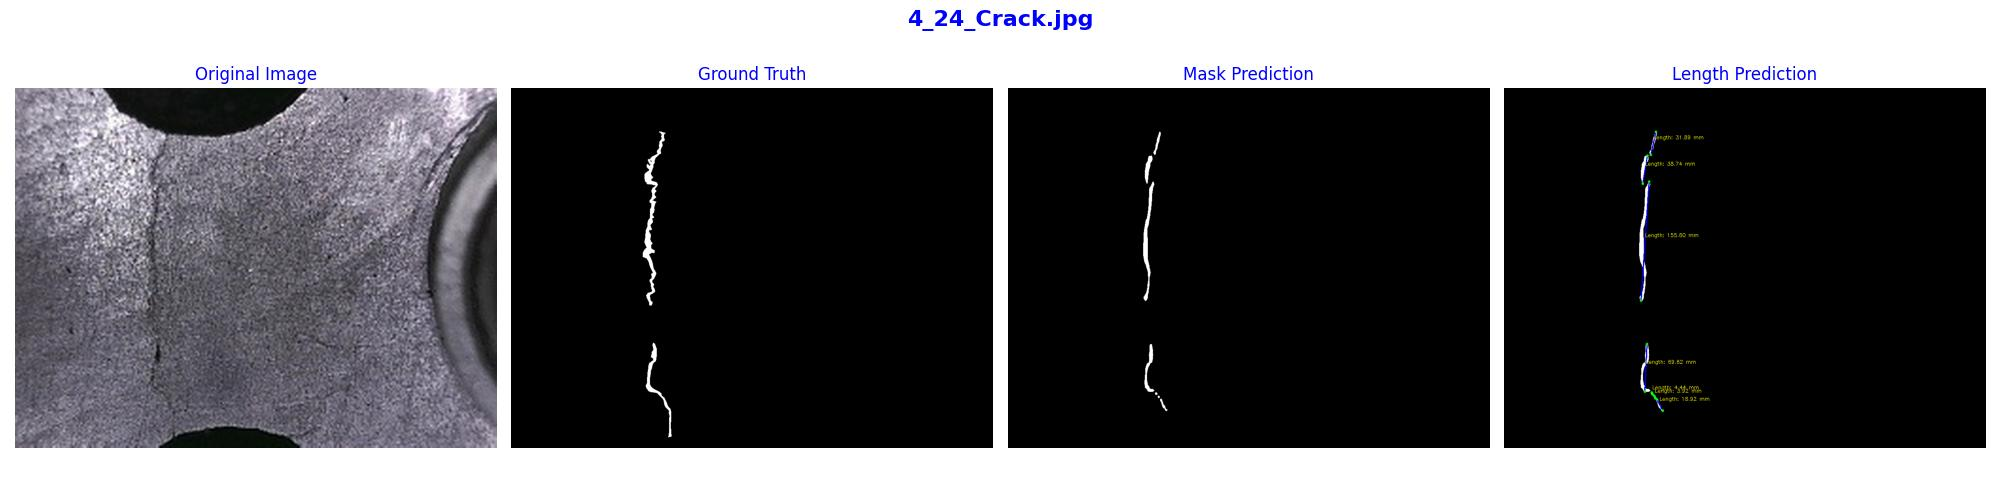